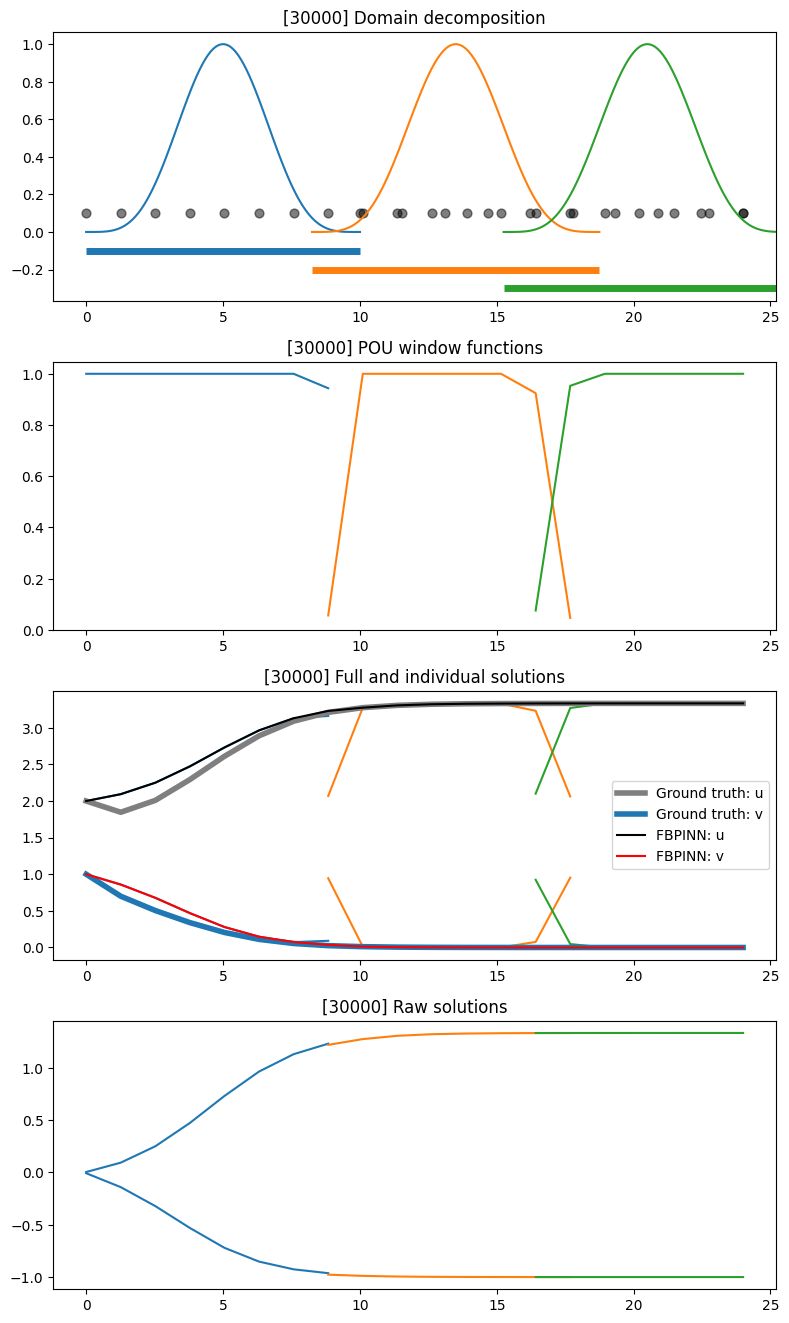

[INFO] 2024-04-01 15:44:38 - [i: 30000/30000] Training complete


In [1]:
import sys
import os

# Paths you want to add to sys.path
paths_to_add = [
    os.path.abspath(os.path.join('../..')),  
    os.path.abspath(os.path.join('..'))  
]

sys.path.extend(path for path in paths_to_add if path not in sys.path)

import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND
domain_init_kwargs = dict(
    xmin = np.array([0.,]),
    xmax = np.array([24.,])
)

domain_init_kwargs

import jax.numpy as jnp
from fbpinns.problems import Problem

from scipy.integrate import odeint
from scipy.interpolate import interp1d

class CompetitionModel(Problem):

    @staticmethod
    def init_params(params=[0.5, 0.7, 0.3, 0.3, 0.6], u0=2, v0=1, sd=0.1):
        
        r, a1, a2, b1, b2 = params 
        static_params = {
            "dims":(2,1),   # dims of solution and problem
            "r_true":r,
            "a1_true":a1,
            "a2_true":a2,
            "b1_true":b1,
            "b2_true":b2,
            "u0":u0,
            "v0":v0,
            "sd":sd,
        }
        trainable_params = {
            "r":jnp.array(0.),
            "a1":jnp.array(0.),
            "a2":jnp.array(0.),
            "b1":jnp.array(0.),
            "b2":jnp.array(0.),
        }
        return static_params, trainable_params
    
    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # Physics Loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, ()),  
            (1, ()),  
            (0, (0,)), 
            (1, (1,)),  
        )

        # Data Loss
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        x_batch_data = jnp.linspace(10, 24, 10).astype(float).reshape((-1,1))
        # r_true, a1_true, a2_true, b1_true, b2_true = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        # params = (r_true, a1_true, a2_true, b1_true, b2_true)
        # solution = odeint(CompetitionModel.model, [u0,v0], x_batch_data.reshape((-1,)), args=(params,))
        solution = CompetitionModel.exact_solution(all_params, x_batch_data)
        u_data = solution[:,0]
        v_data = solution[:,1]
        required_ujs_data = (
            (0, ()), 
            (1, ()),  
        )


        return [[x_batch_phys, required_ujs_phys],
                [x_batch_data, u_data, v_data, required_ujs_data]]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, solution):
        sd = all_params["static"]["problem"]["sd"]
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]

        x, tanh = x_batch[:,0:1], jnp.tanh

        u = solution[:, 0:1] * tanh(x/sd) + u0 # Hard constraining
        v = solution[:, 1:2] * tanh(x/sd)  + v0

        return jnp.concatenate([u, v], axis=1)
    
    @staticmethod
    def loss_fn(all_params, constraints):
        
        r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]

        # Physics loss
        _, u, v, ut, vt = constraints[0]
        phys1 = jnp.mean((ut - u + a1*u**2 + a2*u*v)**2)
        phys2 = jnp.mean((vt - r*v + r*b1*u*v + r*b2*v**2)**2)
        phys = phys1 + phys2

        # Data Loss
        _, ud, vd, u, v = constraints[1]
        u = u.reshape(-1) 
        v = v.reshape(-1) 
        data = 1e6*jnp.mean((u-ud)**2) + 1e6*jnp.mean((v-vd)**2)
        
        return phys + data

    @staticmethod
    def model(y, t, params):
        """
        Compute the derivatives of the system at time t.
        
        :param y: Current state of the system [u, v].
        :param t: Current time.
        :param params: Parameters of the model (a1, a2, b1, b2, r).
        :return: Derivatives [du/dt, dv/dt].
        """
        u, v = y  
        r, a1, a2, b1, b2 = params  
        
        # Define the equations
        du_dt = u * (1 - a1 * u - a2 * v)
        dv_dt = r * v * (1 - b1 * u - b2 * v)
        
        return [du_dt, dv_dt]
    
    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        r, a1, a2, b1, b2 = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        params = [r, a1, a2, b1, b2]
        
        t = jnp.arange(0, 25.02, 0.02)  
        
        # Solve the system 
        solution = odeint(CompetitionModel.model, [u0, v0], t, args=(params,))
        
        # Interpolation 
        u_interp = interp1d(t, solution[:, 0], kind='cubic')
        v_interp = interp1d(t, solution[:, 1], kind='cubic')
        
        u_data = u_interp(x_batch.flatten())
        v_data = v_interp(x_batch.flatten())
        
        # Combine 
        combined_solution = jnp.vstack((u_data, v_data)).T
        if batch_shape:
            combined_solution = combined_solution.reshape(batch_shape + (2,))
        
        return combined_solution
    
    @staticmethod
    def learned_solution(all_params, x_batch):
        # r_true, a1_true, a2_true, b1_true, b2_true = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        params = [r, a1, a2, b1, b2]

        solution = odeint(CompetitionModel.model, [u0, v0], x_batch, args=(params,))

        return solution


# solution = odeint(self._model, initial_conditions, t_span)
# from scipy.integrate import odeint
    
problem = CompetitionModel
# params = [0.5, 0.7, 0.3, 0.3, 0.6]
params = [0.5, 0.3, 0.6, 0.7, 0.3]
problem_init_kwargs = dict(
    params=params, u0=2, v0=1,
)

from fbpinns.decompositions import RectangularDecompositionND
from subdomain_helper import get_subdomain_xsws

decomposition = RectangularDecompositionND
w=1.5
subdomain_xs, subdomain_ws = get_subdomain_xsws([10, 24], 0, 24, 3, w, 1.0005)
decomposition_init_kwargs = dict(
    subdomain_xs = subdomain_xs,
    subdomain_ws = subdomain_ws,
    unnorm = (0., 1.),
)
decomposition_init_kwargs

from fbpinns.networks import FCN

network = FCN# place a fully-connected network in each subdomain
network_init_kwargs=dict(
    layer_sizes=[1,5, 5 ,5,2],# with 2 hidden layers
)

from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((20,),),# use 200 collocation points for training
    n_test=(20,),# use 500 points for testing
    n_steps=30000,# number of training steps
    clear_output=True,
    sampler='grid',
)

from fbpinns.trainers import FBPINNTrainer

run = FBPINNTrainer(c)
all_params = run.train()


In [2]:
from plot import load_FBPINN, load_PINN, exact_solution
from fbpinns.analysis import load_model

out_folder = "test"
c, model = load_model(out_folder, rootdir="results/")

c_0, model_0 = load_model(out_folder, i = 0, rootdir="results/")

[INFO] 2024-04-01 15:44:40 - Loading model from:
results/models/test/model_00030000.jax
[INFO] 2024-04-01 15:44:40 - Loading model from:
results/models/test/model_00000000.jax


Utility functions

In [20]:
from fbpinns.trainers import _common_train_initialisation
from fbpinns.trainers import FBPINN_loss
from jax import random

def get_loss(c, all_params, active, all_opt_states, i):
    key = random.PRNGKey(c.seed)
    domain, problem, decomposition, network = c.domain, c.problem, c.decomposition, c.network
    (_, all_opt_states, _, loss_fn, key, constraints_global, x_batch_global, 
        constraint_offsets_global, constraint_fs_global, 
        jmapss, _, _) = _common_train_initialisation(c, key, all_params, problem, domain)
    
    (active, _, _, 
        active_params, fixed_params, static_params, takess, 
        constraints, _) = run._get_update_inputs(i, active , all_params, all_opt_states ,
                                                        x_batch_global, constraints_global, constraint_fs_global, 
                                                        constraint_offsets_global, decomposition, problem)                          
    # required_ujss = [constraint_[-1] for constraint_ in constraints_global]
    model_fns = (decomposition.norm_fn, network.network_fn, decomposition.unnorm_fn, decomposition.window_fn, problem.constraining_fn)
    lossval = FBPINN_loss(active_params, fixed_params, static_params, takess, constraints, model_fns, jmapss, loss_fn)
    return lossval

def _collect_weights(all_params):
    network_params = all_params["trainable"]["network"]["subdomain"]["layers"]
    problem_params = all_params["trainable"]["problem"]
    x_values = []
    for w, b in network_params:
        for subdomain_weights in w:
            flattened_weights = jnp.array(subdomain_weights).flatten()
            x_values.append(jnp.array(flattened_weights))
        for subdomain_biases in b:
            flattened_biases = jnp.array(subdomain_biases).flatten()
            x_values.append(jnp.array(flattened_biases))
    param_values = jnp.array([float(problem_params[key]) for key in problem_params])
    x_values.append(jnp.array(param_values))
    return x_values

def _update_weights(all_params, x_values):
    idx = 0
    for layer_idx, layer_params in enumerate(all_params["trainable"]["network"]["subdomain"]["layers"]):
        w, b = layer_params 
        w_shapes = [subdomain_w.shape for subdomain_w in w]
        b_shapes = [subdomain_b.shape for subdomain_b in b]
        new_w_subdomain = []
        for shape in w_shapes:
            subdomain_size = jnp.prod(jnp.array(shape))
            new_w_flat = x_values[idx][:subdomain_size].reshape(shape)
            new_w_subdomain.append(new_w_flat)
            idx += 1
        new_w =jnp.stack(new_w_subdomain, axis=0)

        new_b_subdomains = []
        for shape in b_shapes:
            subdomain_size = jnp.prod(jnp.array(shape))
            new_b_flat = x_values[idx][:subdomain_size].reshape(shape)
            new_b_subdomains.append(new_b_flat)
            idx += 1
        new_b = jnp.stack(new_b_subdomains, axis=0)

        all_params["trainable"]["network"]["subdomain"]["layers"][layer_idx] = (new_w, new_b)

        # set problem_params
        problem_keys = list(all_params["trainable"]["problem"].keys())
        for i, key in enumerate(problem_keys):
            all_params["trainable"]["problem"][key] = jnp.array(x_values[idx][i], dtype=jnp.float32)
        return all_params
    

def on_epoch_end(all_params, run, _weight_norm, _loss_value, logs={}):

    c, model = load_model(run, rootdir="results/") # run == outdir
    i, all_params, active, all_opt_states = model[0], model[1], model[3], model[2]

    x_trained = _collect_weights(all_params)
    norm = 2
    _norm = lambda xs: np.linalg.norm(xs, norm)
    _weight_norm.append(_norm(np.concatenate(x_trained)))
    _loss_value.append(get_loss(c, all_params, active, all_opt_states, i))
    logs['norm-loss-weights'] = _weight_norm[-1]



def on_train_end(c, active, all_opt_states, i, all_params,
                 _weight_norm, _resolution, logs={}):
    norm = 2
    _norm = lambda xs: np.linalg.norm(xs, norm)

    x_trained = _collect_weights(all_params)
    x_sizes = [x.size for x in x_trained]
    num_param = sum(x_sizes)
    n0 = np.split(np.random.standard_normal(num_param), np.cumsum(x_sizes))
    n1 = np.split(np.random.standard_normal(num_param), np.cumsum(x_sizes))
    
    n0_norm, n1_norm = [_norm(np.concatenate(ni)) for ni in [n0, n1]]
    n0 = [ni/n0_norm for ni in n0]
    n1 = [ni/n1_norm for ni in n1]

    delta_weights = 2.0 * abs(_weight_norm[-1] - _weight_norm[0])
    print("delta_weights",delta_weights)
    loss_values = np.zeros((_resolution**2, 3))

    k = 0
    for i, l0 in enumerate(np.linspace(-delta_weights, delta_weights, _resolution)):
        for j, l1 in enumerate(np.linspace(-delta_weights, delta_weights, _resolution)):
            test_weights = [xi + n0i*l0 + n1i*l1 for xi,n0i,n1i in zip(x_trained, n0, n1)]
            _update_weights(all_params, test_weights)
            loss_values[k, :] = [l0, l1, get_loss(c, all_params, active, all_opt_states, i)]
            k += 1
            # save the calculations
            np.savetxt(
                "loss-landscape.csv",
                loss_values,
                delimiter=','
            )
    _update_weights(all_params, x_trained)

Initialize

In [21]:
norm = 2
_norm = lambda xs: np.linalg.norm(xs, norm)
c_0, model_0 = load_model(out_folder, i=0, rootdir="results/")
i_0, all_params_0, active_0, all_opt_states_0 = model_0[0], model_0[1], model_0[3], model_0[2]
all_params_0 = model_0[1]

_weight_norm = [_norm(np.concatenate(_collect_weights(all_params_0)))]
print(_weight_norm)
_loss_value  = [get_loss(c_0, all_params_0, active_0, all_opt_states_0, i_0)]
print(_loss_value)

_resolution = 40

[INFO] 2024-04-01 15:51:33 - Loading model from:
results/models/test/model_00000000.jax
[5.111022]
[INFO] 2024-04-01 15:51:33 - Total number of trainable parameters:
[INFO] 2024-04-01 15:51:33 - 	network: 246
[INFO] 2024-04-01 15:51:33 - 	problem: 5
[INFO] 2024-04-01 15:51:33 - Total number of constraints: 2
[INFO] 2024-04-01 15:51:33 - Computing exact solution..
[INFO] 2024-04-01 15:51:33 - Computing done
[INFO] 2024-04-01 15:51:33 - [i: 0/30000] Updating active inputs..
[INFO] 2024-04-01 15:51:33 - [i: 0/30000] Average number of points/dimension in active subdomains: 12.00
[INFO] 2024-04-01 15:51:33 - [i: 0/30000] Updating active inputs done (0.05 s)
[INFO] 2024-04-01 15:51:33 - x_batch
[INFO] 2024-04-01 15:51:33 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 15:51:33 - x_take
[INFO] 2024-04-01 15:51:33 - (23, 1), float32, JVPTracer
[INFO] 2024-04-01 15:51:33 - x_batch
[INFO] 2024-04-01 15:51:33 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 15:51:33 - x_take
[INFO] 2024-04-01 15:5

In [22]:
out_folder = "test"
c, model = load_model(out_folder, rootdir="results/")
i, all_params, active, all_opt_states = model[0], model[1], model[3], model[2]

on_epoch_end(all_params, out_folder, _weight_norm, _loss_value, logs={})
# type(all_params["trainable"]["network"]["subdomain"]["layers"][0][0])

print(_weight_norm)

[INFO] 2024-04-01 15:51:33 - Loading model from:
results/models/test/model_00030000.jax
[INFO] 2024-04-01 15:51:33 - Loading model from:
results/models/test/model_00030000.jax
[INFO] 2024-04-01 15:51:34 - Total number of trainable parameters:
[INFO] 2024-04-01 15:51:34 - 	network: 246
[INFO] 2024-04-01 15:51:34 - 	problem: 5
[INFO] 2024-04-01 15:51:34 - Total number of constraints: 2
[INFO] 2024-04-01 15:51:34 - Computing exact solution..
[INFO] 2024-04-01 15:51:34 - Computing done
[INFO] 2024-04-01 15:51:34 - [i: 30000/30000] Updating active inputs..
[INFO] 2024-04-01 15:51:34 - [i: 30000/30000] Average number of points/dimension in active subdomains: 12.00
[INFO] 2024-04-01 15:51:34 - [i: 30000/30000] Updating active inputs done (0.05 s)
[INFO] 2024-04-01 15:51:34 - x_batch
[INFO] 2024-04-01 15:51:34 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 15:51:34 - x_take
[INFO] 2024-04-01 15:51:34 - (23, 1), float32, JVPTracer
[INFO] 2024-04-01 15:51:34 - x_batch
[INFO] 2024-04-01 15:51:34

In [23]:
on_train_end(c, active, all_opt_states, i, all_params, _weight_norm, _resolution)

delta_weights 2.846755027770996
[INFO] 2024-04-01 15:51:35 - Total number of trainable parameters:
[INFO] 2024-04-01 15:51:35 - 	network: 246
[INFO] 2024-04-01 15:51:35 - 	problem: 5
[INFO] 2024-04-01 15:51:35 - Total number of constraints: 2
[INFO] 2024-04-01 15:51:35 - Computing exact solution..
[INFO] 2024-04-01 15:51:35 - Computing done
[INFO] 2024-04-01 15:51:35 - [i: 0/30000] Updating active inputs..
[INFO] 2024-04-01 15:51:35 - [i: 0/30000] Average number of points/dimension in active subdomains: 12.00


[INFO] 2024-04-01 15:51:35 - [i: 0/30000] Updating active inputs done (0.06 s)
[INFO] 2024-04-01 15:51:35 - x_batch
[INFO] 2024-04-01 15:51:35 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 15:51:35 - x_take
[INFO] 2024-04-01 15:51:35 - (23, 1), float32, JVPTracer
[INFO] 2024-04-01 15:51:35 - x_batch
[INFO] 2024-04-01 15:51:35 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 15:51:35 - x_take
[INFO] 2024-04-01 15:51:35 - (23, 1), float32, JVPTracer
[INFO] 2024-04-01 15:51:35 - x_batch
[INFO] 2024-04-01 15:51:35 - (10, 1), float32, ArrayImpl
[INFO] 2024-04-01 15:51:35 - x_take
[INFO] 2024-04-01 15:51:35 - (13, 1), float32, ArrayImpl
[INFO] 2024-04-01 15:51:35 - Total number of trainable parameters:
[INFO] 2024-04-01 15:51:35 - 	network: 246
[INFO] 2024-04-01 15:51:35 - 	problem: 5
[INFO] 2024-04-01 15:51:35 - Total number of constraints: 2
[INFO] 2024-04-01 15:51:35 - Computing exact solution..
[INFO] 2024-04-01 15:51:35 - Computing done
[INFO] 2024-04-01 15:51:35 - [i: 0/30000] Updatin

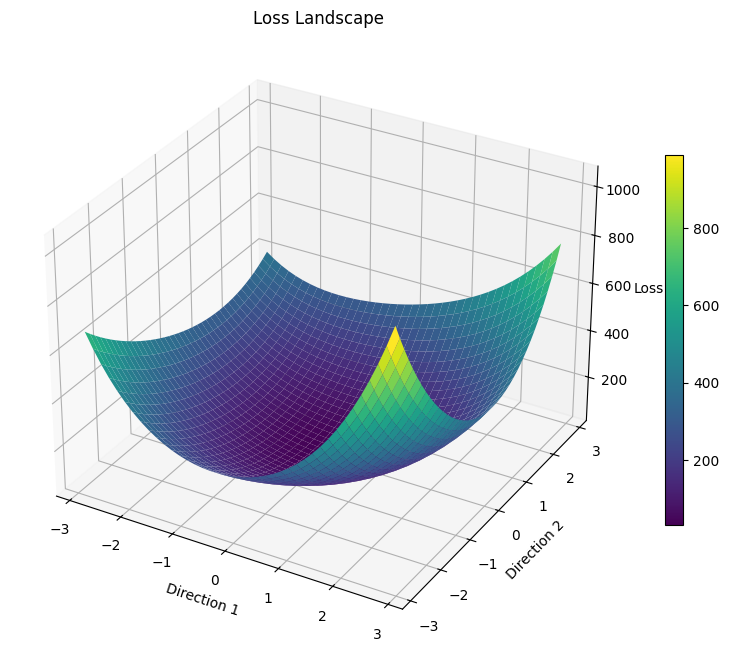

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

file_path = 'loss-landscape.csv'
df = pd.read_csv(file_path, header=None)

x = df[0]
y = df[1]
z = df[2]

resolution = int(np.sqrt(len(z)))
X = x.values.reshape((resolution, resolution))
Y = y.values.reshape((resolution, resolution))
Z = z.values.reshape((resolution, resolution))

# Plotting7
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title('Loss Landscape')
ax.set_xlabel('Direction 1')
ax.set_ylabel('Direction 2')
ax.set_zlabel('Loss')
# fig.colorbar(surf, shrink=0.5, aspect=20)
fig.colorbar(surf, shrink=.6)
plt.show()


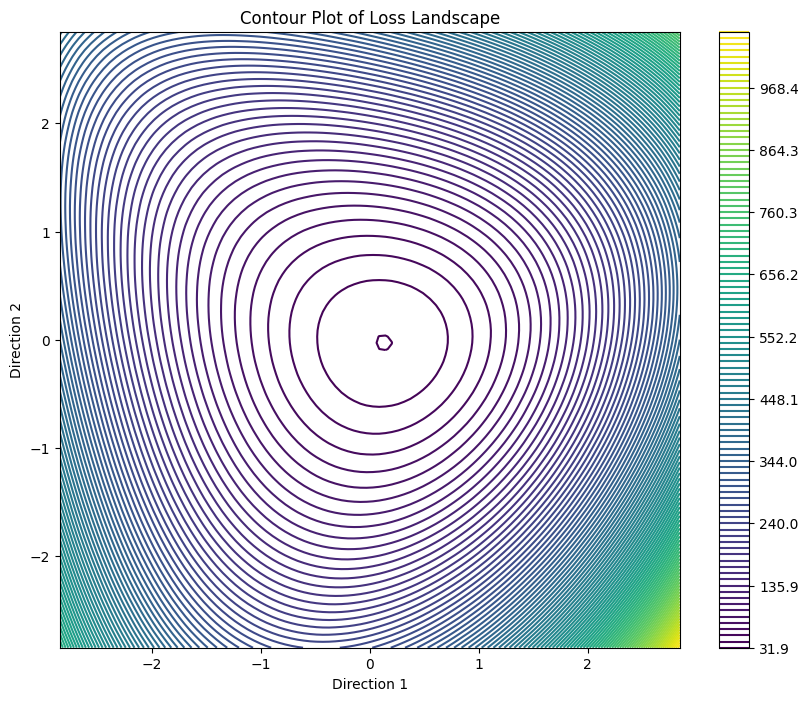

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

df = pd.read_csv('-landscape.csv', header=None)

x = df[0].values
y = df[1].values
z = df[2].values


xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)

# Interpolate z values for this grid.
Z = griddata((x, y), z, (X, Y), method='cubic')


plt.figure(figsize=(10, 8))
contour = plt.contour(X, Y, Z, levels=np.linspace(z.min(), z.max(), 100), cmap=plt.cm.viridis)
plt.colorbar(contour)
plt.title('Contour Plot of Loss Landscape')
plt.xlabel('Direction 1')
plt.ylabel('Direction 2')

plt.show()